In [1]:
%config IPCompleter.greedy=True

from os import path
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
False


In [2]:
import numpy as np
import torchvision
from PIL import Image

from matplotlib import pyplot as plt; plt.style.use('default')
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

In [3]:
transform = ToTensor()
ds = FashionMNIST('./data', train=True, target_transform=None, download=True, transform=transform)
ds_test = FashionMNIST('./data', train=False, target_transform=None, download=True, transform=transform)

In [4]:
print(len(ds))
img, label = ds[0]
print(img.shape)

60000
torch.Size([1, 28, 28])


In [5]:
classes = ds.classes
print(classes)
output_size = len(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Label (numeric): 9
Label (textual): Ankle boot


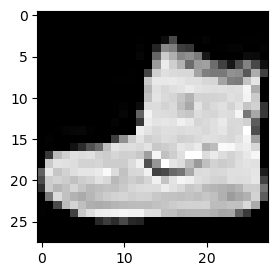

In [6]:
plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(), cmap="gray")
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
            
        training_loss /= len(train_loader.dataset)
        pred_labels = []
        true_labels = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets) 
                valid_loss += loss.data.item() * inputs.size(0)

                true_labels = targets.numpy()
                pred_labels = np.argmax(outputs.numpy(), axis=1)

            valid_loss /= len(val_loader.dataset)
            
        val_acc = accuracy_score(true_labels, pred_labels)
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, 
        training_loss, valid_loss, val_acc))

In [8]:
class FCNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.out(x)
        
    
fcnet = FCNet()
print(fcnet)

FCNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)


In [9]:
batch_size = 128

train_dl = DataLoader(ds, batch_size, shuffle=True)
test_dl = DataLoader(ds_test, batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcnet.parameters(), lr=0.001)

In [10]:
%%timeit -n 1 -r 1
train(fcnet, optimizer, loss_fn, train_dl, test_dl, epochs=10)

Epoch: 1, Training Loss: 0.68, Validation Loss: 0.50, accuracy = 1.00
Epoch: 2, Training Loss: 0.43, Validation Loss: 0.41, accuracy = 0.81
Epoch: 3, Training Loss: 0.37, Validation Loss: 0.40, accuracy = 0.88
Epoch: 4, Training Loss: 0.34, Validation Loss: 0.38, accuracy = 0.56
Epoch: 5, Training Loss: 0.32, Validation Loss: 0.35, accuracy = 0.88
Epoch: 6, Training Loss: 0.30, Validation Loss: 0.36, accuracy = 0.75
Epoch: 7, Training Loss: 0.29, Validation Loss: 0.36, accuracy = 0.88
Epoch: 8, Training Loss: 0.28, Validation Loss: 0.35, accuracy = 0.75
Epoch: 9, Training Loss: 0.26, Validation Loss: 0.35, accuracy = 0.75
Epoch: 10, Training Loss: 0.26, Validation Loss: 0.34, accuracy = 0.94
2min 50s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
torch.save(fcnet.state_dict(), "fcnet.pt")

In [10]:
fcnet.load_state_dict(torch.load("fcnet.pt", map_location=device))

<All keys matched successfully>

In [32]:
for X, y in test_dl:
    X, y = X.to(device), y.to(device)
    break

In [18]:
def plot_images(X, y, yp, M, N):
    f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N, M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].detach().numpy(), cmap="gray")
            pred_label = yp[i*N+j].max(dim=0)[1]
            title = ax[i][j].set_title("{} -> {}".format(y[i*N+j], pred_label))
            plt.setp(title, color=('g' if pred_label == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

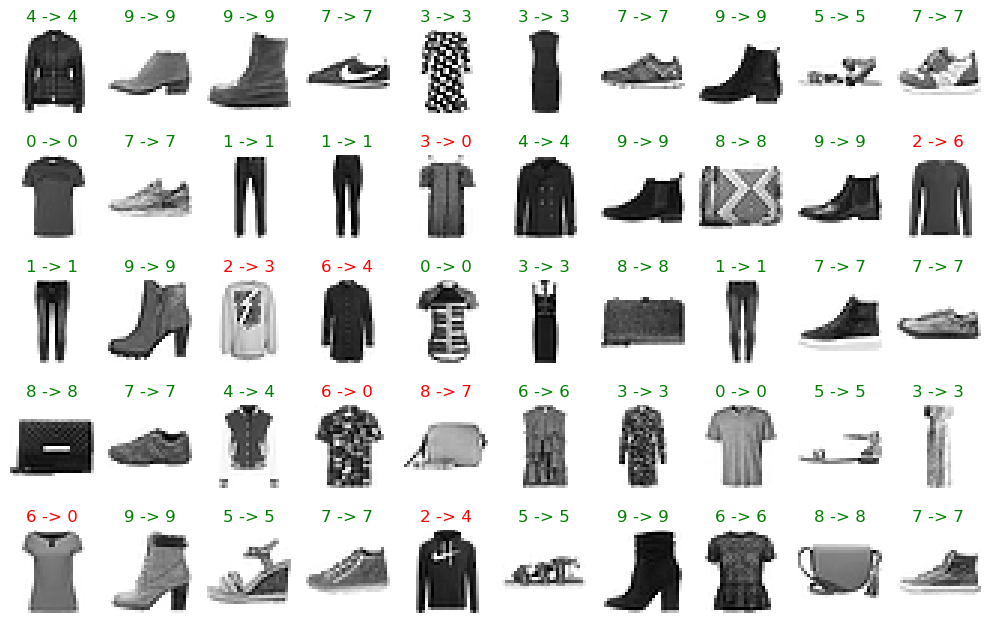

In [31]:
### Illustrate original predictions
yp = fcnet(X)
plot_images(X, y, yp, 5, 10)

In [21]:
def clip(x, x_, eps):
    lower_clip = torch.max(torch.stack([torch.zeros_like(x), x - eps, x_]), dim=0)[0]
    return torch.min(torch.stack([torch.ones_like(x), x + eps, lower_clip]), dim=0)[0]


def make_noise(model, loss_fn, examples, targets, max_iter=1, alpha=1.0,
               clip_eps=1/255, do_clip=False, minimize=False, ifgsm=False):

    direction = -1 if minimize else 1
    if ifgsm:
        alpha /= max_iter
    
    adv_ex = examples.clone()
    noise = torch.zeros_like(adv_ex, requires_grad=True)
    
    for _ in range(max_iter):
        noise.requires_grad = True
        model.zero_grad()

        loss = loss_fn(model(adv_ex+noise), targets)
        loss.backward()
        noise = direction * alpha * noise.grad.sign()

        if do_clip:
            adv_ex = clip(adv_ex, adv_ex+noise, clip_eps)
        else:
            adv_ex += noise

    return noise

In [22]:
def fgsm(model, loss_fn, examples, targets, alpha=0.1, max_iter=1):
    return make_noise(model, loss_fn, examples, targets, max_iter=max_iter, alpha=alpha)



def ifgsm(model, loss_fn, examples, targets, max_iter=5, alpha=0.1, clip_eps=1/255, do_clip=True, ifgsm=True):
    return make_noise(model, loss_fn, examples, targets, max_iter=max_iter, alpha=alpha, 
                      clip_eps=clip_eps, do_clip=do_clip)


def llc(model, loss_fn, examples, max_iter=10, alpha=0.1, clip_eps=8/255):
    last_lilely_targets = model(examples).argmin(dim=1).detach()
    return make_noise(model, loss_fn, examples, last_lilely_targets, max_iter=max_iter, 
                               alpha=alpha, do_clip=True, clip_eps=clip_eps, minimize=True)

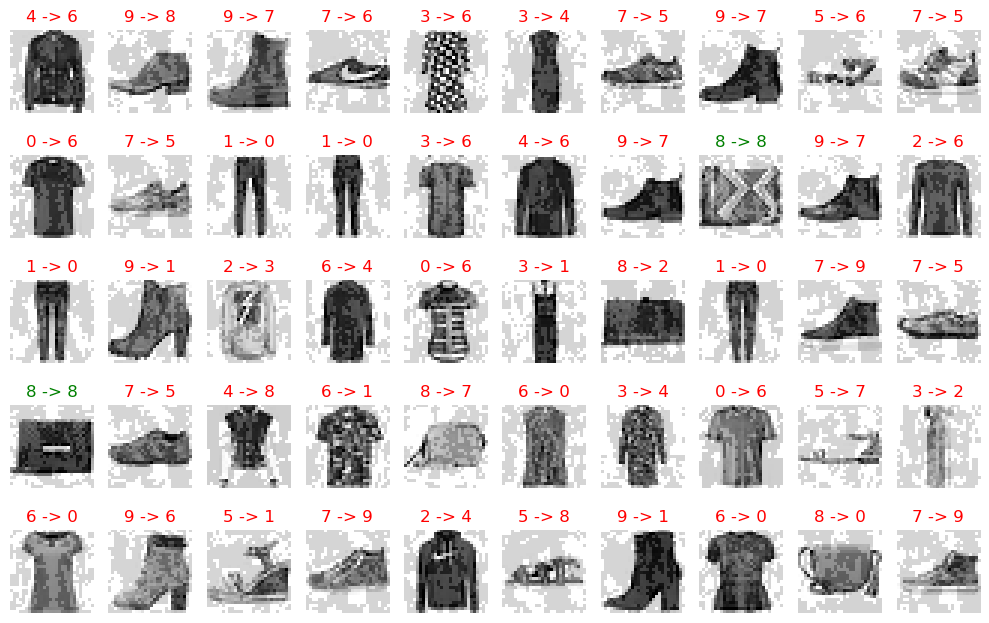

In [34]:
noise = fgsm(fcnet, nn.CrossEntropyLoss(), X, y, alpha=0.1)
yp = fcnet(X+noise)
plot_images(X+noise, y, yp, 5, 10)

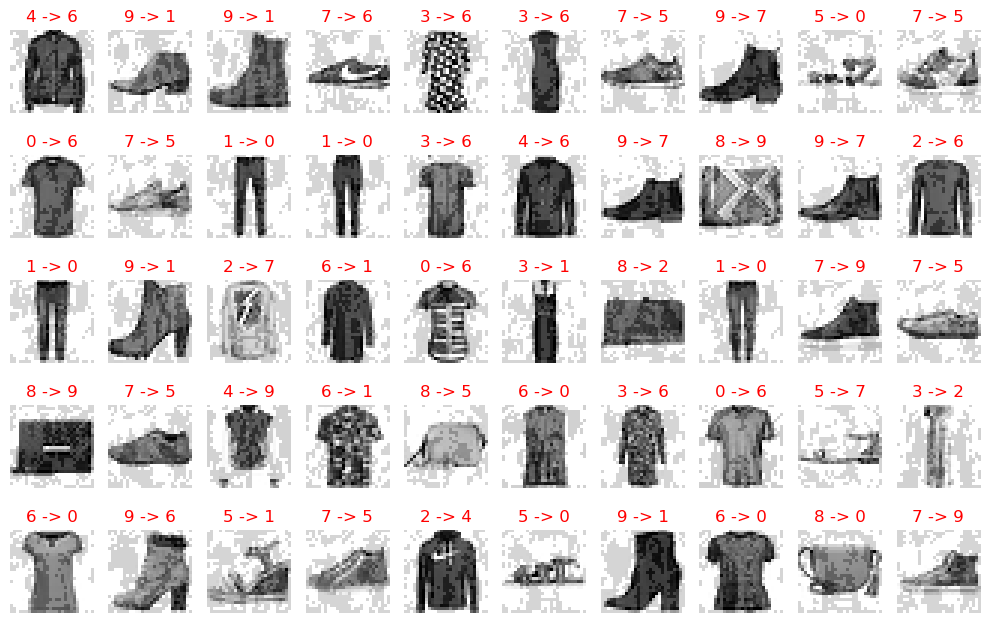

In [35]:
noise = ifgsm(fcnet, nn.CrossEntropyLoss(), X, y, alpha=0.1, max_iter=5, clip_eps=8/255, do_clip=True)
yp = fcnet(X+noise)
plot_images(X+noise, y, yp, 5, 10)

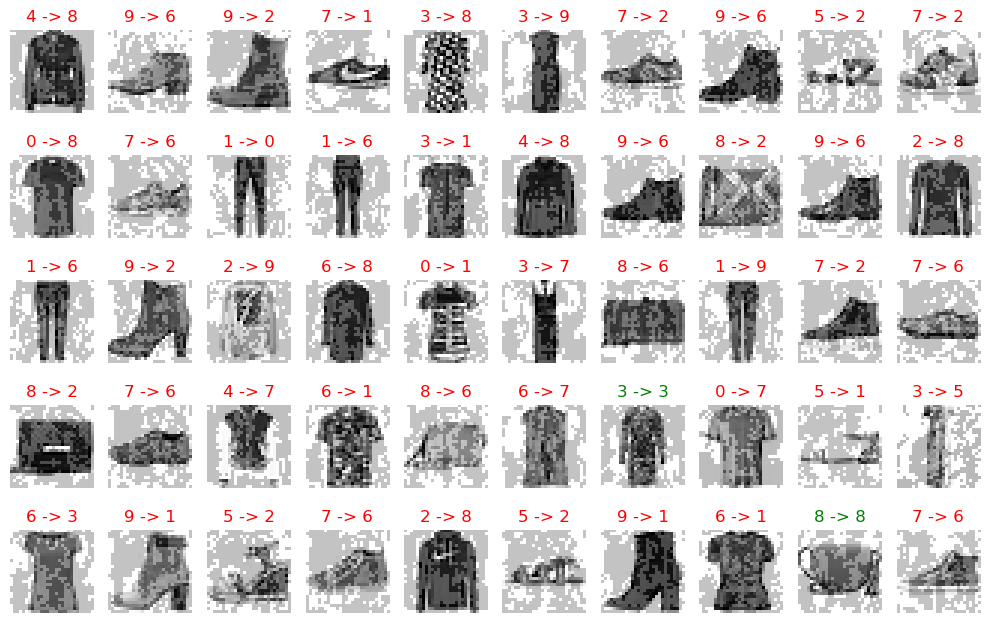

In [36]:
noise = llc(fcnet, nn.CrossEntropyLoss(), X, max_iter=5, alpha=0.15, clip_eps=1/255)
yp = fcnet(X+noise)
plot_images(X+noise, y, yp, 5, 10)

In [38]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
         )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
cnn = CNN()

In [39]:
batch_size = 64

train_dl = DataLoader(ds, batch_size, shuffle=True)
test_dl = DataLoader(ds_test, batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [40]:
%%timeit -n 1 -r 1
train(cnn, optimizer, loss_fn, train_dl, test_dl, epochs=10)

Epoch: 1, Training Loss: 0.66, Validation Loss: 0.49, accuracy = 0.75
Epoch: 2, Training Loss: 0.42, Validation Loss: 0.40, accuracy = 0.75
Epoch: 3, Training Loss: 0.36, Validation Loss: 0.37, accuracy = 1.00
Epoch: 4, Training Loss: 0.33, Validation Loss: 0.34, accuracy = 0.88
Epoch: 5, Training Loss: 0.30, Validation Loss: 0.34, accuracy = 0.81
Epoch: 6, Training Loss: 0.28, Validation Loss: 0.33, accuracy = 0.88
Epoch: 7, Training Loss: 0.27, Validation Loss: 0.31, accuracy = 0.88
Epoch: 8, Training Loss: 0.25, Validation Loss: 0.29, accuracy = 0.94
Epoch: 9, Training Loss: 0.24, Validation Loss: 0.30, accuracy = 0.88
Epoch: 10, Training Loss: 0.23, Validation Loss: 0.29, accuracy = 0.94
4min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
torch.save(fcnet.state_dict(), "cnn.pt")

In [ ]:
fcnet.load_state_dict(torch.load("cnn.pt", map_location=device))

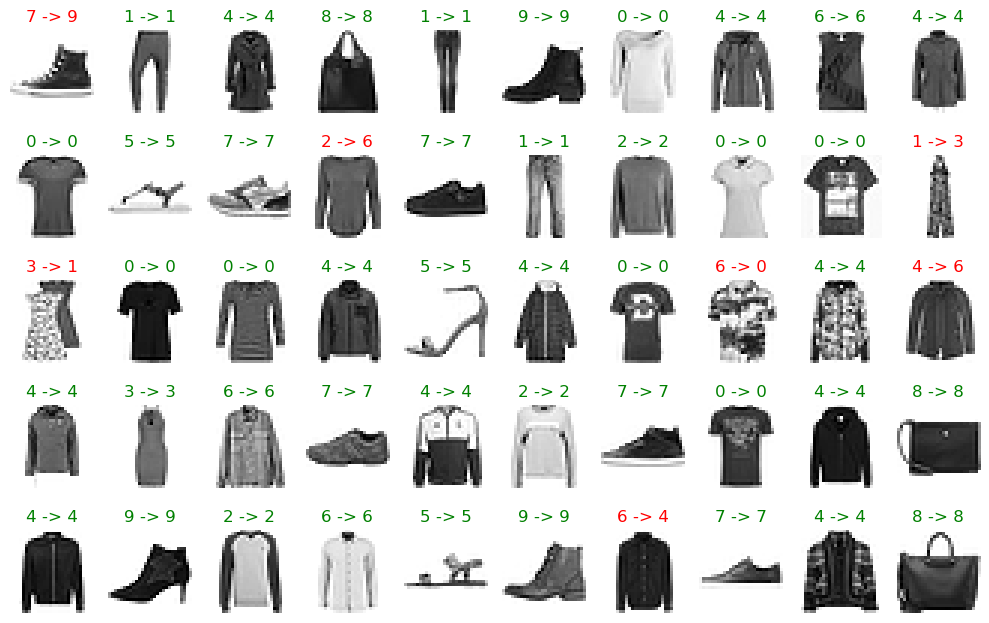

In [41]:
### Illustrate original predictions
yp = cnn(X)
plot_images(X, y, yp, 5, 10)

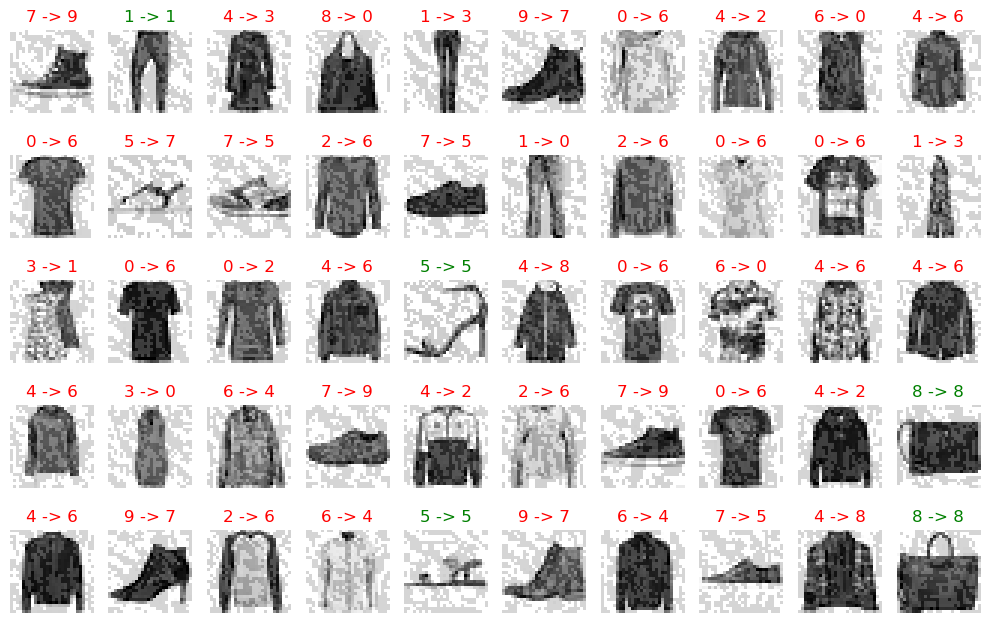

In [42]:
noise = fgsm(cnn, nn.CrossEntropyLoss(), X, y, alpha=0.1)
yp = cnn(X+noise)
plot_images(X+noise, y, yp, 5, 10)

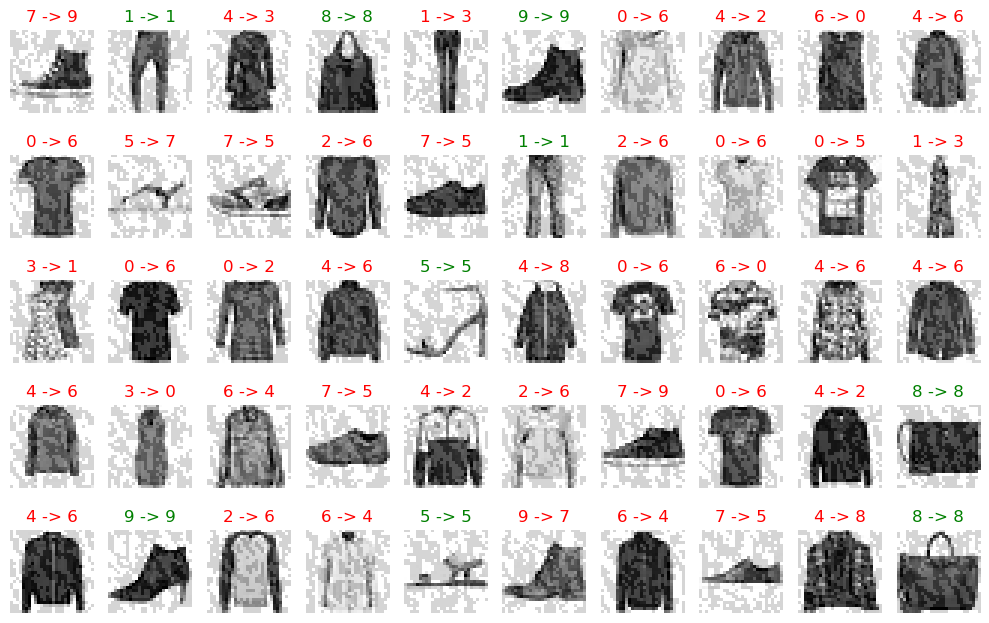

In [43]:
noise = ifgsm(cnn, nn.CrossEntropyLoss(), X, y, alpha=0.1, max_iter=5, clip_eps=8/255, do_clip=True)
yp = cnn(X+noise)
plot_images(X+noise, y, yp, 5, 10)

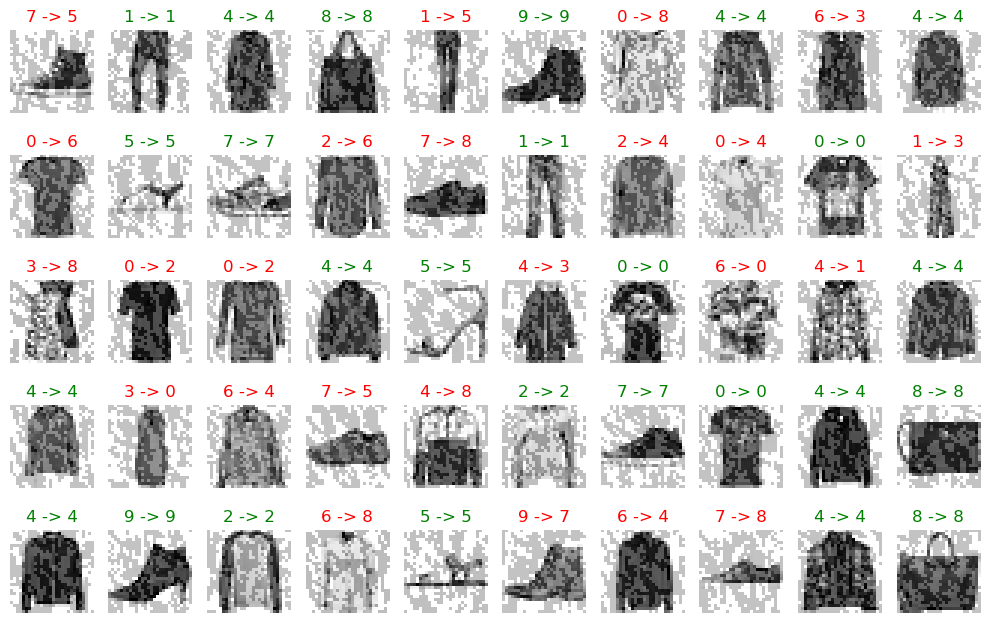

In [46]:
noise = llc(cnn, nn.CrossEntropyLoss(), X, max_iter=10, alpha=0.15, clip_eps=1/255)
yp = cnn(X+noise)
plot_images(X+noise, y, yp, 5, 10)